In [ ]:
import json
import os
import yaml
import importlib
from pathlib import Path
import datetime
import shutil
import utils

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd



from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


from torch import utils
# import pytorch_lightning as pl
import lightning.pytorch as pl


from deepS2S.model import ViTLSTM, IndexLSTM

from deepS2S.utils.utils_build import statics_from_config
from deepS2S.utils.utils_data import generate_clim_pred, load_data
from deepS2S.utils.utils_model import test_model_and_data, best_model_folder
from deepS2S.utils.utils_evaluation import *
from deepS2S.utils.plot_utils import *

In [2]:
import matplotlib as mpl
mpl.get_configdir()

'/mnt/beegfs/home/bommer1/.config/matplotlib'

In [3]:
plt.style.use('seaborn')


/tmp/ipykernel_68665/2955780531.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
def classwise_CSI(pred_classes, targets):
    n_classes = int(np.max(targets) + 1)
    preds = np.eye(n_classes)[pred_classes.astype(int)]

    tars = np.eye(n_classes)[targets.astype(int)]
    csi_cw = np.zeros((targets.shape[1],n_classes))
    for i in range(n_classes):
        pred = preds[:,:,i]
        target = tars[:,:,i]
        for j in range(target.shape[1]):
            tp = pred[target[:,j].astype(bool),j].sum()
            fn = target[:,j].sum() - tp
            
            fp = pred[:,j].sum() - tp 
            csi_cw[j,i] = (tp/(tp + fn +fp))#/target[:,j].sum()
    return csi_cw  

In [5]:
def classwise_ACC(pred_classes, targets):
    ts = targets.shape[1]
    n_classes = pred_classes.max() + 1

    acc_cw = np.zeros((ts,n_classes))
    for t in range(ts): 
        pdc = pred_classes[:,t]
        tgt = targets[:,t]
        tgs = np.eye(n_classes)[tgt]
        pds = np.eye(n_classes)[pdc]
        for i in range(n_classes):

            occ_correct = (tgs[:,i].flatten().astype(int) == pds[:,i].flatten().astype(int))* tgs[:,i].astype(int)
            acc_cw[t,i] = occ_correct.sum()/tgs[:,i].sum()
    return acc_cw

## Model and Prediction Function

# Results

In [ ]:
# Set hyperparameters.
arch_type = 'Index_LSTM' # 'LSTM' # 'ViT'
cm_list = ['#7fbf7b','#1b7837','#762a83','#9970ab','#c2a5cf'] 
regimes = ['SB', 'NAO-', 'AR', 'NAO+']

exd = os.path.dirname(os.path.abspath(__file__))
cfd = exd.parent.absolute()

root_path = str(cfd.parent.absolute())+'/Data'
data_path = f"{root_path}/"
res_path = str(cfd.parent.absolute()) + f'/Data/Results/'

config_vit = yaml.load(open(f'{cfd}/config/config_1980_olr.yaml'), Loader=yaml.FullLoader)


strt_yr = config_vit.get('strt','')
trial_num = config_vit.get('version', '')
norm_opt = config_vit.get('norm_opt','')
arch = config_vit.get('arch', 'ViT')
tropics_vit = config_vit.get('tropics', '')
temp_scaling = config_vit.get('temp_scaling', False)

stat_dir =  config_vit['net_root'] + f'Statistics/{arch}'
result_path = f'{data_path}Results/Statistics/{arch}/'
results_directory = Path(f'{result_path}version_{strt_yr}{trial_num}_{norm_opt}{tropics_vit}/')
os.makedirs(results_directory, exist_ok=True)


mod_name = 'ViT_LSTM'
architecture = ViTLSTM.ViT_LSTM

        
arch_lstm = 'LSTM'
config_lstm = yaml.load(open(f'{cfd}/config/config_1980_olr_lstm.yaml'), Loader=yaml.FullLoader)


strt_yr = config_lstm.get('strt','')
trial_num = config_lstm.get('version', '')
norm_opt = config_lstm.get('norm_opt','')
arch = config_lstm.get('arch', 'ViT')
tropics = config_lstm.get('tropics', '')
temp_scaling = config_lstm.get('temp_scaling', False)

stat_dir_lstm =  config_lstm['net_root'] + f'Statistics/{arch_lstm}/'
result_pat_lstm = f'{res_path}Statistics/{arch_lstm}/'
results_dir_lstm = Path(f'{result_pat_lstm}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/')
os.makedirs(results_dir_lstm, exist_ok=True)

arch_index = 'Index_LSTM'
cfile = '_1980_index'
config_index = yaml.load(open(f'{cfd}/config/config_1980_index.yaml'), Loader=yaml.FullLoader)


strt_yr = config_index.get('strt','')
trial_num = config_index.get('version', '')
norm_opt = config_index.get('norm_opt','')
arch = config_index.get('arch', 'ViT')
tropics = config_index.get('tropics', '')
temp_scaling = config_index.get('temp_scaling', False)


stat_dir_index =  config_index['net_root'] + f'Statistics/{arch_index}/'
result_pat_index = f'{res_path}Statistics/{arch_index}/'
results_dir_index = Path(f'{result_pat_index}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/')
os.makedirs(results_dir_index, exist_ok=True)
mod_name = 'Index_LSTM'
architecture_index = IndexLSTM.Index_LSTM



test_loader, data_set, cls_wt, test_set, infos = load_data(config_vit)

var_comb_index = config_index['var_comb']

data_info, _ = statics_from_config(config_vit)

seasons =  {'train':{config_vit['data']['dataset_name2']:list(range(config_vit['data']['fine']['train_start'], config_vit['data']['fine']['train_end']))},
'val':{config_vit['data']['dataset_name2']:list(range(config_vit['data']['fine']['val_start'],config_vit['data']['fine']['val_end']))},
'test':{config_vit['data']['dataset_name2']:list(range(config_vit['data']['fine']['test_start'], config_vit['data']['fine']['test_end']))}}

~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc


In [7]:
# Load collected data.
exp_dir =  f"{stat_dir}version_{strt_yr}{trial_num}_{norm_opt}{tropics_vit}/"
pths = [xs for xs in Path(exp_dir).iterdir() if xs.is_dir()]

if temp_scaling:
    data_collect = np.load(f'{results_directory}/collected_loop_data_{len(pths)-1}_temp_scale.npz')
    data_result = np.load(f'{results_directory}/accuracy_{len(pths)-1}model_temp_scale.npz')
else:
    data_collect = np.load(f'{results_directory}/collected_loop_data_{len(pths)-1}.npz')
    data_result = np.load(f'{results_directory}/accuracy_{len(pths)-1}model.npz')
    
persistance = data_collect['persistance'] 
dates = data_collect['dates'] 
daytimes = data_collect['daytimes']
loop_probabilities_vit = data_collect['loop_probabilities']
loop_classes_vit = data_collect['loop_classes']
targets = data_collect['targets']
predictions_baseline = data_collect['predictions_baseline']



In [8]:
# Load collected data.
exp_dir_lstm =  f"{stat_dir_lstm}version_{strt_yr}{trial_num}_{norm_opt}{tropics_vit}/"
pths_lstm = [xs for xs in Path(exp_dir_lstm).iterdir() if xs.is_dir()]

if temp_scaling:
    data_collect_lstm = np.load(f'{results_dir_lstm}/collected_loop_data_{len(pths_lstm)-1}_temp_scale.npz')
    data_result_lstm = np.load(f'{results_dir_lstm}/accuracy_{len(pths_lstm)-1}model_temp_scale.npz')
else:
    data_collect_lstm = np.load(f'{results_dir_lstm}/collected_loop_data_{len(pths_lstm)-1}.npz')
    data_result_lstm = np.load(f'{results_dir_lstm}/accuracy_{len(pths_lstm)-1}model.npz')
    
loop_probabilities_lstm = data_collect_lstm['loop_probabilities']
loop_classes_lstm = data_collect_lstm['loop_classes']

In [9]:
# Load collected data.
exp_dir_index =  f"{stat_dir_index}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/"
pths_index= [xs for xs in Path(exp_dir_index).iterdir() if xs.is_dir()]

if temp_scaling:
    data_collect_index = np.load(f'{results_dir_index}/collected_loop_data_{len(pths_index)-1}_temp_scale.npz')
    data_result_index = np.load(f'{results_dir_index}/accuracy_{len(pths_index)-1}model_temp_scale.npz')
else:
    data_collect_index = np.load(f'{results_dir_index}/collected_loop_data_{len(pths_index)-1}.npz')
    data_result_index = np.load(f'{results_dir_index}/accuracy_{len(pths_index)-1}model.npz')
    
loop_probabilities_index = data_collect_index['loop_probabilities']
loop_classes_index = data_collect_index['loop_classes']

In [10]:
input_reg = []
for input, output, weeks, days in data_set:
    if arch_type == 'Index_LSTM':
        input_reg.append(input[1][None,:,-4:].numpy().squeeze())
    else:
        input_reg.append(np.array(input[1]).squeeze())


input_reg = np.concatenate(input_reg).reshape((predictions_baseline.shape[0],
                                                           predictions_baseline.shape[1],4))

In [11]:
# load climatology
smoothing = 7
num_m = 14
dtset_name = config_vit['data']['dataset_name2']

clim_prob = xr.load_dataarray(f'/mnt/beegfs/home/bommer1/WiOSTNN/Version1/data/{dtset_name}/climatology/NAE_{num_m}eofs_prob_{smoothing}days_climatology_1980_2009.nc')
predictions_clim = generate_clim_pred(clim_prob, dates)
predictions_clim_classes = np.argmax(predictions_clim, 2)


In [ ]:
# Load the CSV file into a DataFrame
leads = [6,13,20,27,34,40]


# Load the CSV file into a DataFrame
file_path = f'{data_path}Results/Statistics/ViT/version_1980_calibrated_olr/csi_results_2501.csv'
df_csi = pd.read_csv(file_path)

file_path = f'{data_path}Results/Statistics/ViT/version_1980_calibrated_olr/acc.csv'
df_acc = pd.read_csv(file_path)

file_path = f'{data_path}Results/Statistics/ViT/version_1980_calibrated_olr/precision_hindcast.csv'
df_prec = pd.read_csv(file_path)

# Access CSI
hindcast_csi_mean_values = df_csi['weighted mean'].values
hindcast_mean_csi = hindcast_csi_mean_values[leads]
hindcast_csi = {r: []for r in regimes}
for i, r in enumerate(regimes):
    hindcast_csi[r] = df_csi[r].values[leads]
hindcast_csi_array = np.array([hindcast_csi[r] for r in regimes]).T

#Access Precision
hindcast_mean_precision = df_prec['weighted mean'].values
hindcast_mean_prec = hindcast_mean_precision[leads]
# Plot class-wise accuracy over time steps
hindcast_precision = {r: []for r in regimes}
for i, r in enumerate(regimes):
    hindcast_precision[r] = df_prec[r].values[leads]
hindcast_precision_array = np.array([hindcast_precision[r] for r in regimes])

# Access accuracy
hindcast_accuracy = df_acc['weighted mean'].values[leads]
hindcast_acc = {r: []for r in regimes}
for i, r in enumerate(regimes):
    hindcast_acc[r] = df_acc[r].values[leads]
hindcast_acc_array = np.array([hindcast_acc[r] for r in regimes]).T


## Calculate ACC, CSI and Precision

### ACC

In [14]:
loop_acc_cw_vit = []
loop_acc_cw_index = []
loop_acc_cw_lstm = []
loop_acc_vit = []
loop_acc_lstm = []
loop_acc_index = []
for mod in range(loop_classes_vit.shape[0]):
    pred_vit = loop_classes_vit[mod]
    pred_lstm = loop_classes_lstm[mod]
    pred_index = loop_classes_index[mod]

    loop_acc_cw_vit.append(classwise_ACC(pred_vit, targets)[None,...])
    loop_acc_cw_lstm.append(classwise_ACC(pred_lstm, targets)[None,...])
    loop_acc_cw_index.append(classwise_ACC(pred_index, targets)[None,...])

    loop_acc_vit.append(balanced_accuracy(pred_vit, targets)[0][None,...])
    loop_acc_lstm.append(balanced_accuracy(pred_lstm, targets)[0][None,...])
    loop_acc_index.append(balanced_accuracy(pred_index, targets)[0][None,...])

loop_acc_cw_vit = np.concatenate(loop_acc_cw_vit)
loop_acc_cw_lstm = np.concatenate(loop_acc_cw_lstm)
loop_acc_cw_index = np.concatenate(loop_acc_cw_index)

loop_acc_vit = np.concatenate(loop_acc_vit)
loop_acc_lstm = np.concatenate(loop_acc_lstm)
loop_acc_index = np.concatenate(loop_acc_index)


acc_cw_vit = np.mean(loop_acc_cw_vit, axis=0)
acc_cw_lstm = np.mean(loop_acc_cw_lstm, axis=0)
acc_cw_index = np.mean(loop_acc_cw_index, axis=0)

acc_vit = np.mean(loop_acc_vit, axis=0)
acc_lstm = np.mean(loop_acc_lstm, axis=0)
acc_index = np.mean(loop_acc_index, axis=0)

std_acc_vit = np.std(loop_acc_vit, axis=0)
std_acc_lstm = np.std(loop_acc_lstm, axis=0)
std_acc_index = np.std(loop_acc_index, axis=0)

acc_pers_cw = classwise_ACC(persistance, targets)

In [ ]:
lr_stats = np.load('/mnt/beegfs/home/bommer1/WiOSTNN/Data/Results/Statistics/ViT/version_1980_calibrated_olr/lr_accuracy_97model.npz')
aurora_stats = np.load('/mnt/beegfs/home/bommer1/WiOSTNN/Data/Results/Statistics/ViT/version_1980_calibrated_olr/AURORA_accuracy_97model.npz')

mean_lr, std_lr = lr_stats['mean_acc'], lr_stats['std_acc']
mean_aurora, std_aurora = aurora_stats['mean_acc'], aurora_stats['std_acc']


overall_accuracy_persist, _ = balanced_accuracy(persistance, targets)
overall_accuracy_clim, _ = balanced_accuracy(predictions_clim_classes, targets)


In [16]:
# Define the models and their corresponding mean and std values
models_mean = ['Persistence', 'Hindcast', 'Logistic Regression', 'LSTM', 'LSTM-Index', 'Aurora-ViT','ViT-LSTM']
mean_values = [overall_accuracy_persist, hindcast_accuracy, mean_lr, acc_lstm, acc_index, mean_aurora, acc_vit]
models_std = [ 'Logistic Regression', 'LSTM', 'LSTM-Index', 'Aurora-ViT', 'ViT']
std_values = [ std_lr, std_acc_lstm, std_acc_index, std_aurora, std_acc_vit]

# Create DataFrames for mean and std values
mean_df = pd.DataFrame(mean_values, index=models_mean, columns=[f'Timestep {i+1}' for i in range(6)])
std_df = pd.DataFrame(std_values, index=models_std, columns=[f'Timestep {i+1}' for i in range(6)])

In [17]:
mean_df

,Timestep 1,Timestep 2,Timestep 3,Timestep 4,Timestep 5,Timestep 6
Persistence,0.540544,0.317083,0.253285,0.222635,0.160001,0.236251
Hindcast,0.660976,0.460976,0.364634,0.334146,0.295122,0.289024
Logistic Regression,0.356566,0.325257,0.268869,0.204606,0.160389,0.233013
LSTM,0.390067,0.274155,0.221445,0.186814,0.209883,0.197634
LSTM-Index,0.249392,0.296306,0.297206,0.243995,0.226828,0.211324
Aurora-ViT,36.675116,26.036229,25.610371,21.509467,21.797711,20.998797
ViT-LSTM,0.279344,0.292949,0.318645,0.330891,0.340463,0.291559


In [18]:
std_df

,Timestep 1,Timestep 2,Timestep 3,Timestep 4,Timestep 5,Timestep 6
Logistic Regression,3.885781e-16,5.551115e-16,7.216450e-16,1.942890e-16,1.665335e-16,2.498002e-16
LSTM,2.922097e-02,1.238292e-02,7.860605e-03,1.262284e-02,1.432185e-02,1.216044e-02
LSTM-Index,8.868314e-03,1.226086e-02,9.124423e-03,1.180469e-02,1.071047e-02,1.515520e-02
Aurora-ViT,1.116116e+00,9.867992e-01,1.517653e+00,1.690440e+00,1.252945e+00,1.686327e+00
ViT,1.442504e-02,1.729320e-02,1.427392e-02,1.761926e-02,1.739540e-02,1.986756e-02


### CSI

In [19]:
loop_csi_vit = []
loop_csi_index_lstm = []
loop_csi_lstm = []
loop_csi_cw_vit = []
loop_csi_cw_index_lstm = []
loop_csi_cw_lstm = []
for mod in range(loop_classes_vit.shape[0]):
    pred_vit = loop_classes_vit[mod]
    pred_lstm = loop_classes_lstm[mod]
    pred_index = loop_classes_index[mod]

    loop_csi_cw_vit.append(classwise_CSI(pred_vit, targets)[None,...])
    loop_csi_cw_lstm.append(classwise_CSI(pred_lstm, targets)[None,...])
    loop_csi_cw_index_lstm.append(classwise_CSI(pred_index, targets)[None,...])
    loop_csi_vit.append(CSI_multiclass(pred_vit, targets)[None,...])
    loop_csi_lstm.append(CSI_multiclass(pred_lstm, targets)[None,...])
    loop_csi_index_lstm.append(CSI_multiclass(pred_index, targets)[None,...])

loop_csi_vit = np.concatenate(loop_csi_vit)
loop_csi_lstm = np.concatenate(loop_csi_lstm)
loop_csi_index_lstm = np.concatenate(loop_csi_index_lstm)
loop_csi_cw_vit = np.concatenate(loop_csi_cw_vit)
loop_csi_cw_lstm = np.concatenate(loop_csi_cw_lstm)
loop_csi_cw_index_lstm = np.concatenate(loop_csi_cw_index_lstm)

csi_vit = np.mean(loop_csi_vit, axis=0)
csi_lstm = np.mean(loop_csi_lstm, axis=0)
csi_index_lstm = np.mean(loop_csi_index_lstm, axis=0)
csi_cw_vit = np.mean(loop_csi_cw_vit, axis=0)
csi_cw_lstm = np.mean(loop_csi_cw_lstm, axis=0)
csi_cw_index_lstm = np.mean(loop_csi_cw_index_lstm, axis=0)

persistance_cw_csi = classwise_CSI(persistance, targets)
persistance_csi = CSI_multiclass(persistance, targets)


### Precision

In [20]:
loop_prec_cw_vit = []
loop_prec_cw_lstm = []
loop_prec_cw_index = []
loop_prec_vit = []
loop_prec_lstm = []
loop_prec_index = []

for mod in range(loop_classes_vit.shape[0]):
    pred_vit = loop_classes_vit[mod]
    pred_lstm = loop_classes_lstm[mod]
    pred_index = loop_classes_index[mod]

    precision_stnn, precision_mean_stnn = calculate_precision(pred_vit, targets, regimes)
    precision_lstm, precision_mean_lstm = calculate_precision(pred_lstm, targets, regimes)
    precision_lstm_index, precision_mean_lstm_index = calculate_precision(pred_index, targets, regimes)

    loop_prec_cw_vit.append(precision_stnn.values[None,...])
    loop_prec_cw_lstm.append(precision_lstm.values[None,...])
    loop_prec_cw_index.append(precision_lstm_index.values[None,...])
    loop_prec_vit.append(precision_mean_stnn[None,...])
    loop_prec_lstm.append(precision_mean_lstm[None,...])
    loop_prec_index.append(precision_mean_lstm_index[None,...])

loop_prec_cw_vit = np.concatenate(loop_prec_cw_vit)
loop_prec_cw_lstm = np.concatenate(loop_prec_cw_lstm)
loop_prec_cw_index = np.concatenate(loop_prec_cw_index)
loop_prec_vit = np.concatenate(loop_prec_vit)
loop_prec_lstm = np.concatenate(loop_prec_lstm)
loop_prec_index = np.concatenate(loop_prec_index)

prec_vit = np.mean(loop_prec_vit, axis=0)
prec_lstm = np.mean(loop_prec_lstm, axis=0)
prec_index = np.mean(loop_prec_index, axis=0)

prec_cw_vit = np.mean(loop_prec_cw_vit, axis=0)
prec_cw_lstm = np.mean(loop_prec_cw_lstm, axis=0)
prec_cw_index = np.mean(loop_prec_cw_index, axis=0)
    
precision_pers, precision_mean_pers = calculate_precision(persistance, targets, regimes)
precision_pers = precision_pers.values

## Plots

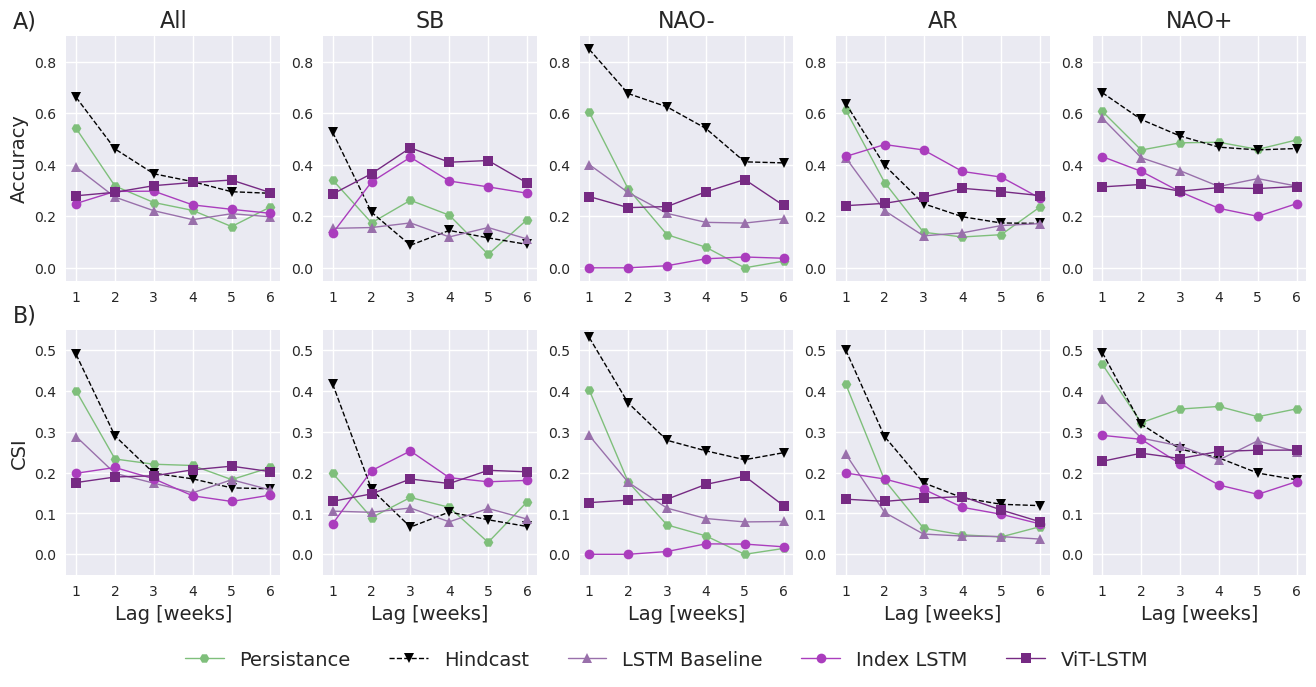

In [ ]:
# Plot class-wise accuracy over time steps
num_time_steps, num_classes = acc_pers_cw.shape
fig, axes_all = plt.subplots(2, num_classes+1,figsize=(16,7))
annotations = ['A)', 'B)']
color_r = [cm_list[0],'k', cm_list[3], '#aa3dbd', cm_list[2]]
marks = ['H', 'v','^', 'o', 's']

# Accuracy
axes = axes_all[0,:]

axes[0].plot(range(num_time_steps), overall_accuracy_persist,label=f'Persistence', color = cm_list[0], marker='H',  linewidth=1)
axes[0].plot(range(num_time_steps), hindcast_accuracy,label=f'Hindcast', color = 'k', marker='v', linewidth=1, linestyle= '--')
axes[0].plot(range(num_time_steps), acc_lstm,label=f'LSTM', color = cm_list[3], marker='^', linewidth=1)
axes[0].plot(range(num_time_steps), acc_index,label=f'LSTM-Index', color = '#aa3dbd', marker='o',  linewidth=1)
axes[0].plot(range(num_time_steps), acc_vit, label=f'ViT-LSTM', color = cm_list[2], marker='s', linewidth=1)
axes[0].set_xticks(range(num_time_steps))
axes[0].set_xticklabels(range(1,7))
axes[0].set_title(f'All', fontsize=16)
axes[0].set_ylim(-0.05, 0.9)
axes[0].set_ylabel('Accuracy', fontsize=14)
axes[0].annotate(annotations[0], xy=(0, 1), xycoords='axes fraction', 
                    xytext=(-30, 10), textcoords='offset points', 
                    fontsize=16, va='center', ha='center')

for class_idx in range(1, num_classes+1):
    ax = axes[class_idx]
    class_idx = class_idx - 1

    ax.plot(range(num_time_steps), acc_pers_cw[:,class_idx],label=f'Persistence ', color = cm_list[0], marker='H',  linewidth=1)
    ax.plot(range(num_time_steps), hindcast_acc_array[:,class_idx],label=f'Hindcast', color = 'k', marker='v', linewidth=1, linestyle= '--')
    ax.plot(range(num_time_steps), acc_cw_lstm[:,class_idx],label=f'LSTM', color = cm_list[3], marker='^', linewidth=1)
    ax.plot(range(num_time_steps), acc_cw_index[:,class_idx],label=f'LSTM-Index', color = '#aa3dbd', marker='o',  linewidth=1)
    ax.plot(range(num_time_steps), acc_cw_vit[:,class_idx], label=f'ViT-LSTM', color = cm_list[2], marker='s', linewidth=1)

    ax.set_xticks(range(num_time_steps))
    ax.set_xticklabels(range(1,7))
    ax.set_title(f'{regimes[class_idx]}', fontsize=16)
    ax.set_ylim(-0.05, 0.9)

# CSI
csi_all =[]
axes = axes_all[1,:]
colors = cm_list
i = 0
linestyle = ['-', '--','-', '-', '-']

for var, label in zip(['persistance_csi','hindcast_mean_csi', 'csi_lstm','csi_index_lstm','csi_vit'], ['Persistance', 'Hindcast', 'LSTM Baseline', 'Index LSTM', 'ViT-LSTM']):

    axes[0].plot(np.arange(len(locals()[var])), locals()[var], label=label, c = color_r[i], marker=marks[i],  linewidth=1, linestyle = linestyle[i])
    i+=1
axes[0].set_xticks(range(num_time_steps))
axes[0].set_xticklabels(range(1,7))
axes[0].set_xlabel('Lag [weeks]', fontsize=14)
axes[0].set_ylim(-0.05, 0.55)
axes[0].set_ylabel('CSI', fontsize=14)
axes[0].annotate(annotations[1], xy=(0, 1), xycoords='axes fraction', 
                    xytext=(-30, 10), textcoords='offset points', 
                    fontsize=16, va='center', ha='center')


linestyle = ['-','--', '-', '-', '-']

for class_idx in range(1, num_classes+1):
    ax = axes[class_idx]
    class_idx = class_idx - 1
    i = 0
    for var, label in zip(['persistance_cw_csi', 'hindcast_csi_array','csi_cw_lstm','csi_cw_index_lstm','csi_cw_vit'], ['Persistance', 'Hindcast','LSTM Baseline', 'Index LSTM', 'ViT-LSTM']):
        ax.plot(np.arange(len(locals()[var][:,class_idx])), locals()[var][:,class_idx], label=label, c = color_r[i], marker=marks[i],  linewidth=1, linestyle = linestyle[i])
        i +=1

    ax.set_ylim(-0.05, 0.55)
    ax.set_xticks(range(num_time_steps))
    ax.set_xticklabels(range(1,7))
    ax.set_xlabel('Lag [weeks]', fontsize=14)
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,fontsize=14, loc='lower center',bbox_to_anchor=(0.5, -0.05), ncol=5)    
fig.savefig(f"{results_directory}/csi_preds.png", dpi=600, bbox_inches='tight')

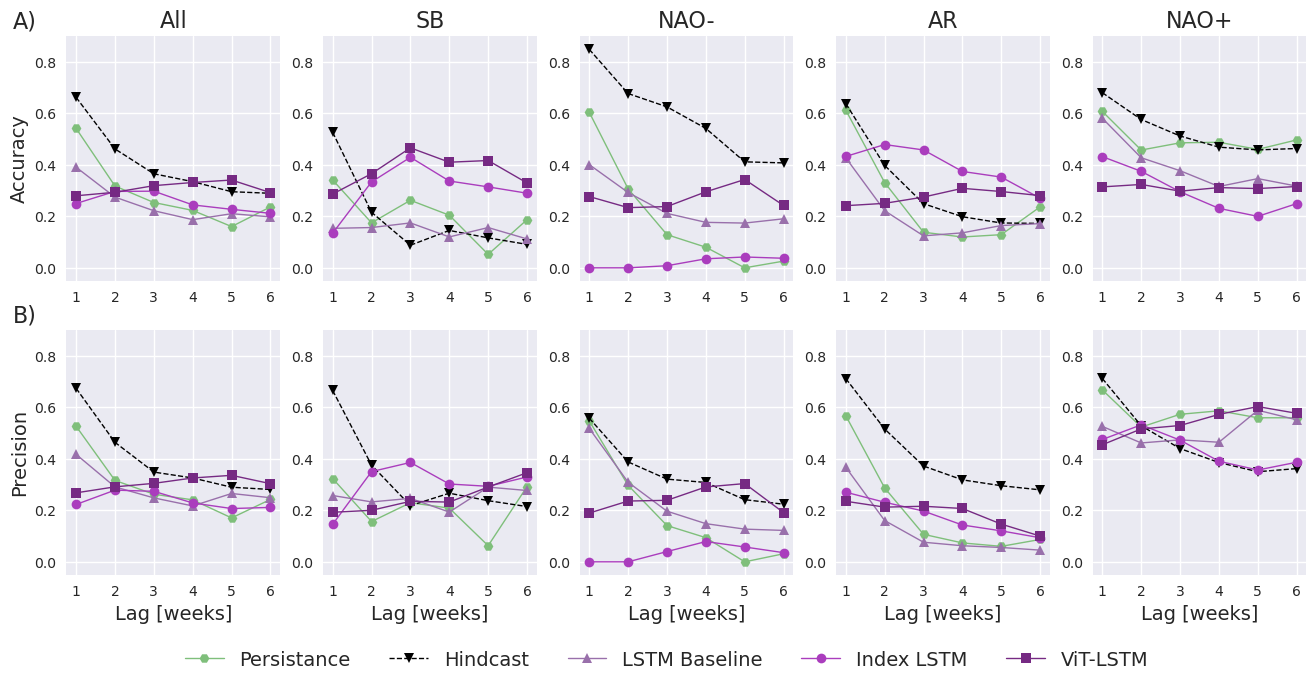

In [ ]:
# Plot class-wise accuracy over time steps

fig, axes_all = plt.subplots(2, num_classes+1,figsize=(16,7))
annotations = ['A)', 'B)']
color_r = [cm_list[0],'k', cm_list[3], '#aa3dbd', cm_list[2]]
marks = ['H', 'v','^', 'o', 's']

# Accuracy
axes = axes_all[0,:]

axes[0].plot(range(num_time_steps), overall_accuracy_persist,label=f'Persistence', color = cm_list[0], marker='H',  linewidth=1)
axes[0].plot(range(num_time_steps), hindcast_accuracy,label=f'Hindcast', color = 'k', marker='v', linewidth=1, linestyle= '--')
axes[0].plot(range(num_time_steps), acc_lstm,label=f'LSTM', color = cm_list[3], marker='^', linewidth=1)
axes[0].plot(range(num_time_steps), acc_index,label=f'LSTM-Index', color = '#aa3dbd', marker='o',  linewidth=1)
axes[0].plot(range(num_time_steps), acc_vit, label=f'ViT-LSTM', color = cm_list[2], marker='s', linewidth=1)
axes[0].set_xticks(range(num_time_steps))
axes[0].set_xticklabels(range(1,7))
axes[0].set_title(f'All', fontsize=16)
axes[0].set_ylim(-0.05, 0.9)
axes[0].set_ylabel('Accuracy', fontsize=14)
axes[0].annotate(annotations[0], xy=(0, 1), xycoords='axes fraction', 
                    xytext=(-30, 10), textcoords='offset points', 
                    fontsize=16, va='center', ha='center')

for class_idx in range(1, num_classes+1):
    ax = axes[class_idx]
    class_idx = class_idx - 1

    ax.plot(range(num_time_steps), acc_pers_cw[:,class_idx],label=f'Persistence ', color = cm_list[0], marker='H',  linewidth=1)
    ax.plot(range(num_time_steps), hindcast_acc_array[:,class_idx],label=f'Hindcast', color = 'k', marker='v', linewidth=1, linestyle= '--')
    ax.plot(range(num_time_steps), acc_cw_lstm[:,class_idx],label=f'LSTM', color = cm_list[3], marker='^', linewidth=1)
    ax.plot(range(num_time_steps), acc_cw_index[:,class_idx],label=f'LSTM-Index', color = '#aa3dbd', marker='o',  linewidth=1)
    ax.plot(range(num_time_steps), acc_cw_vit[:,class_idx], label=f'ViT-LSTM', color = cm_list[2], marker='s', linewidth=1)

    ax.set_xticks(range(num_time_steps))
    ax.set_xticklabels(range(1,7))
    ax.set_title(f'{regimes[class_idx]}', fontsize=16)
    ax.set_ylim(-0.05, 0.9)

# CSI
csi_all =[]
axes = axes_all[1,:]
colors = cm_list
i = 0
linestyle = ['-','--', '-', '-', '-']

for var, label in zip(['precision_mean_pers','hindcast_mean_prec', 'prec_lstm','prec_index','prec_vit'], ['Persistance', 'Hindcast', 'LSTM Baseline', 'Index LSTM', 'ViT-LSTM']):

    precis = locals()[var]
    axes[0].plot(np.arange(len(precis)), precis, label=label, c = color_r[i], marker=marks[i],  linewidth=1, linestyle = linestyle[i])

    i+=1
axes[0].set_xticks(range(num_time_steps))
axes[0].set_xticklabels(range(1,7))
axes[0].set_xlabel('Lag [weeks]', fontsize=14)
# axes[0].set_title(f'All', fontsize=16)
axes[0].set_ylim(-0.05, 0.9)
axes[0].set_ylabel('Precision', fontsize=14)
axes[0].annotate(annotations[1], xy=(0, 1), xycoords='axes fraction', 
                    xytext=(-30, 10), textcoords='offset points', 
                    fontsize=16, va='center', ha='center')


linestyle = ['-','--', '-', '-', '-']

for class_idx in range(1, num_classes+1):
    ax = axes[class_idx]
    class_idx = class_idx - 1
    i = 0
    for var, label in zip(['precision_pers', 'hindcast_precision_array','prec_cw_lstm','prec_cw_index','prec_cw_vit'], ['Persistance', 'Hindcast','LSTM Baseline', 'Index LSTM', 'ViT-LSTM']):
        ax.plot(np.arange(len(locals()[var][class_idx,:])), locals()[var][class_idx,:], label=label, c = color_r[i], marker=marks[i],  linewidth=1, linestyle = linestyle[i])
        i +=1

    ax.set_ylim(-0.05, 0.9)
    ax.set_xticks(range(num_time_steps))
    ax.set_xticklabels(range(1,7))
    ax.set_xlabel('Lag [weeks]', fontsize=14)
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,fontsize=14, loc='lower center',bbox_to_anchor=(0.5, -0.05), ncol=5)    
fig.savefig(f"{results_directory}/csi_preds.png", dpi=600, bbox_inches='tight')